# Weight Sampling Tutorial

If you want to fine-tune one of the trained original SSD models on your own dataset, chances are that your dataset doesn't have the same number of classes as the trained model you're trying to fine-tune.

This notebook explains a few options for how to deal with this situation. In particular, one solution is to sub-sample (or up-sample) the weight tensors of all the classification layers so that their shapes correspond to the number of classes in your dataset.

This notebook explains how this is done.

## 0. Our example

I'll use a concrete example to make the process clear, but of course the process explained here is the same for any dataset.

Consider the following example. You have a dataset on road traffic objects. Let this dataset contain annotations for the following object class of interest:

`['cell']`

That is, your dataset contains annotations for only 1 object class.

You would now like to train an SSD300 on this dataset. However, instead of going through all the trouble of training a new model from scratch, you would instead like to use the fully trained original SSD300 model that was trained on MS COCO and fine-tune it on your dataset.

The problem is: The SSD300 that was trained on MS COCO predicts 80 different classes, but your dataset has only 1 class. The weight tensors of the classification layers of the MS COCO model don't have the right shape for your model that is supposed to learn only 1 class. Bummer.

So what options do we have?

### Option 1: Just ignore the fact that we need only 1 class

The maybe not so obvious but totally obvious option is: We could just ignore the fact that the trained MS COCO model predicts 80 different classes, but we only want to fine-tune it on 1 class. We could simply map the 1 class in our annotated dataset to any 1 indice out of the 80 that the MS COCO model predicts. The class ID in our dataset could be any one out of the 80. Whatever we would choose it to be, the point is that we would be training only 1 out of every 80 neurons that predict the class for a given box and the other 79 would simply not be trained. Nothing would happen to them, because the gradient for them would always be zero, because these indices don't appear in our dataset.

This would work, and it wouldn't even be a terrible option. Since only 1 out of the 80 classes would get trained, the model might get gradually worse at predicting the other 79 clases, but we don't care about them anyway, at least not right now. And if we ever realize that we now want to predict more than 1 different class, our model would be expandable in that sense. Any new class we want to add could just get any one of the remaining free indices as its ID. We wouldn't need to change anything about the model, it would just be a matter of having the dataset annotated accordingly.

Still, in this example we don't want to take this route. We don't want to carry around the computational overhead of having overly complex classifier layers, 90 percent of which we don't use anyway, but still their whole output needs to be computed in every forward pass.

So what else could we do instead?

### Option 2: Just ignore those weights that are causing problems

We could build a new SSD300 with 1 class and load into it the weights of the MS COCO SSD300 for all layers except the classification layers. Would that work? Yes, that would work. The only conflict is with the weights of the classification layers, and we can avoid this conflict by simply ignoring them. While this solution would be easy, it has a significant downside: If we're not loading trained weights for the classification layers of our new SSD300 model, then they will be initialized randomly. We'd still benefit from the trained weights for all the other layers, but the classifier layers would need to be trained from scratch.

Not the end of the world, but we like pre-trained stuff, because it saves us a lot of training time. So what else could we do?

### Option 3: Sub-sample the weights that are causing problems

Instead of throwing the problematic weights away like in option 2, we could also sub-sample them. If the weight tensors of the classification layers of the MS COCO model don't have the right shape for our new model, we'll just **make** them have the right shape. This way we can still benefit from the pre-trained weights in those classification layers. Seems much better than option 2.

If MS COCO happens to contain all the classes that we care about, then we can sub-sample the weight tensors of the classification layers and we won't just do so randomly. Instead, we'll pick exactly those elements from the tensor that are responsible for the classification of the _n_ classes that we care about.

However, even if the classes in your dataset were entirely different from the classes in any of the fully trained models, it would still make a lot of sense to use the weights of the fully trained model. Any trained weights are always a better starting point for the training than random initialization, even if your model will be trained on entirely different object classes.

And of course, in case you happen to have the opposite problem, where your dataset has **more** classes than the trained model you would like to fine-tune, then you can simply do the same thing in the opposite direction: Instead of sub-sampling the classification layer weights, you would then **up-sample** them. Works just the same way as what we'll be doing below.

Let's get to it.

In [1]:
import h5py
import numpy as np
import shutil

from misc_utils.tensor_sampling_utils import sample_tensors

## 1. Load the trained weights file and make a copy

First, we'll load the HDF5 file that contains the trained weights that we need (the source file). In our case this is "`VGG_VOC0712Plus_SSD_512x512_ft_iter_160000.h5`" (download link available in the README of this repo), which are the weights of the original SSD300 model that was trained on MS COCO.

Then, we'll make a copy of that weights file. That copy will be our output file (the destination file).

In [2]:
# TODO: Set the path for the source weights file you want to load.
weights_source_path = 'VGG_VOC0712Plus_SSD_512x512_iter_240000.h5'

# TODO: Set the path and name for the destination weights file
#       that you want to create.
weights_destination_path = 'VGG_VOC0712Plus_SSD_512x512_iter_240000_subsampled_1_class.h5'

# Make a copy of the weights file.
shutil.copy(weights_source_path, weights_destination_path)

'VGG_VOC0712Plus_SSD_512x512_iter_240000_subsampled_1_class.h5'

In [3]:
# Load both the source weights file and the copy we made.
# We will load the original weights file in read-only mode so that we can't mess up anything.
weights_source_file = h5py.File(weights_source_path, 'r')
weights_destination_file = h5py.File(weights_destination_path)

## 2. Figure out which weight tensors we need to sub-sample

Next, we need to figure out exactly which weight tensors we need to sub-sample. As mentioned above, the weights for all layers except the classification layers are fine, we don't need to change anything about those.

So which are the classification layers in SSD300? Their names are:

In [4]:
classifier_names = ['conv4_3_norm_mbox_conf',
                    'fc7_mbox_conf',
                    'conv6_2_mbox_conf',
                    'conv7_2_mbox_conf',
                    'conv8_2_mbox_conf',
                    'conv9_2_mbox_conf',
                    'conv10_2_mbox_conf']

## 3. Figure out which slices to pick

The following section is optional. I'll look at one classification layer and explain what we want to do, just for your understanding. If you don't care about that, just skip ahead to the next section.

We know which weight tensors we want to sub-sample, but we still need to decide which (or at least how many) elements of those tensors we want to keep. Let's take a look at the first of the classifier layers, "`conv4_3_norm_mbox_conf`". Its two weight tensors, the kernel and the bias, have the following shapes:

In [5]:
conv4_3_norm_mbox_conf_kernel = weights_source_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias   = weights_source_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 84)
bias:	 (84,)


So the last axis has 84 elements. Why is that?

- PASCAL VOC has 20 classes, but the model also has one 'backgroud' class, so that makes 21 classes effectively.
- The 'conv4_3_norm_mbox_loc' layer predicts 4 boxes for each spatial position, so the 'conv4_3_norm_mbox_conf' layer has to predict one of the 21 classes for each of those 4 boxes.

That's why the last axis has 4 * 21 = 84 elements.

So how many elements do we want in the last axis for this layer?

Let's do the same calculation as above:

- Our dataset has only 1 class, but our model will also have a 'background' class, so that makes 2 classes effectively.
- We need to predict one of those 2 classes for each of the four boxes at each spatial position.

That makes 4 * 2 = 8 elements.

Now we know that we want to keep 8 elements in the last axis and leave all other axes unchanged. But which 8 elements out of the original 84 elements do we want?

Should we just pick them randomly? If the object classes in our dataset had absolutely nothing to do with the classes in PASCAL VOC, then choosing those 8 elements randomly would be fine.

Here are the indices of the 2 classes in PASCAL VOC that we are interested in:

`[0, 1]`

The indices above represent the following classes in the PASCAL VOC datasets:

`['background', 'aeroplane']`

How did I find out those indices? I just looked them up in the annotations of the PASCAL VOC dataset.

So out of every 21 in the 84 elements, I want to pick the 2 elements above. This gives us the following 8 indices:

In [6]:
n_classes_source = 21
classes_of_interest = [0, 1]

subsampling_indices = []
for i in range(int(84/n_classes_source)):
    indices = np.array(classes_of_interest) + i * n_classes_source
    subsampling_indices.append(indices)
subsampling_indices = list(np.concatenate(subsampling_indices))

print(subsampling_indices)

[0, 1, 21, 22, 42, 43, 63, 64]


These are the indices of the 8 elements that we want to pick from both the bias vector and from the last axis of the kernel tensor.

This was the detailed example for the '`conv4_3_norm_mbox_conf`' layer. And of course we haven't actually sub-sampled the weights for this layer yet, we have only figured out which elements we want to keep. The piece of code in the next section will perform the sub-sampling for all the classifier layers.

## 4. Sub-sample the classifier weights

The code in this section iterates over all the classifier layers of the source weights file and performs the following steps for each classifier layer:

1. Get the kernel and bias tensors from the source weights file.
2. Compute the sub-sampling indices for the last axis. The first three axes of the kernel remain unchanged.
3. Overwrite the corresponding kernel and bias tensors in the destination weights file with our newly created sub-sampled kernel and bias tensors.

The second step does what was explained in the previous section.

In case you want to **up-sample** the last axis rather than sub-sample it, simply set the `classes_of_interest` variable below to the length you want it to have. The added elements will be initialized either randomly or optionally with zeros. Check out the documentation of `sample_tensors()` for details.

In [7]:
# TODO: Set the number of classes in the source weights file. Note that this number must include
#       the background class, so for PASCAL VOC's 20 classes, this must be 20 + 1 = 21.
n_classes_source = 21

# TODO: Set the indices of the classes that you want to pick for the sub-sampled weight tensors.
#       In case you would like to just randomly sample a certain number of classes, you can just set
#       `classes_of_interest` to an integer instead of the list below. Either way, don't forget to
#       include the background class. That is, if you set an integer, and you want `n` positive classes,
#       then you must set `classes_of_interest = n + 1`.
classes_of_interest = [0, 1]
# classes_of_interest = 2 # Uncomment this in case you want to just randomly sub-sample the last axis instead of providing a list of indices.

for name in classifier_names:
    # Get the trained weights for this layer from the source HDF5 weights file.
    kernel = weights_source_file[name][name]['kernel:0'].value
    bias   = weights_source_file[name][name]['bias:0'].value

    # Get the shape of the kernel. We're interested in sub-sampling
    # the last dimension, 'o'.
    height, width, in_channels, out_channels = kernel.shape
    
    # Compute the indices of the elements we want to sub-sample.
    # Keep in mind that each classification predictor layer predicts multiple
    # bounding boxes for every spatial location, so we want to sub-sample
    # the relevant classes for each of these boxes.
    if isinstance(classes_of_interest, (list, tuple)):
        subsampling_indices = []
        for i in range(int(out_channels/n_classes_source)):
            indices = np.array(classes_of_interest) + i * n_classes_source
            subsampling_indices.append(indices)
        subsampling_indices = list(np.concatenate(subsampling_indices))
    elif isinstance(classes_of_interest, int):
        subsampling_indices = int(classes_of_interest * (out_channels/n_classes_source))
    else:
        raise ValueError("`classes_of_interest` must be either an integer or a list/tuple.")
    
    # Sub-sample the kernel and bias.
    # The `sample_tensors()` function used below provides extensive
    # documentation, so don't hesitate to read it if you want to know
    # what exactly is going on here.
    new_kernel, new_bias = sample_tensors(weights_list=[kernel, bias],
                                          sampling_instructions=[height, width, in_channels, subsampling_indices],
                                          axes=[[3]], # The one bias dimension corresponds to the last kernel dimension.
                                          init=['gaussian', 'zeros'],
                                          mean=0.0,
                                          stddev=0.005)
    
    # Delete the old weights from the destination file.
    del weights_destination_file[name][name]['kernel:0']
    del weights_destination_file[name][name]['bias:0']
    # Create new datasets for the sub-sampled weights.
    weights_destination_file[name][name].create_dataset(name='kernel:0', data=new_kernel)
    weights_destination_file[name][name].create_dataset(name='bias:0', data=new_bias)

# Make sure all data is written to our output file before this sub-routine exits.
weights_destination_file.flush()

/home/abasso/Amanda/ic/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


That's it, we're done.

Let's just quickly inspect the shapes of the weights of the '`conv4_3_norm_mbox_conf`' layer in the destination weights file:

In [8]:
conv4_3_norm_mbox_conf_kernel = weights_destination_file[classifier_names[0]][classifier_names[0]]['kernel:0']
conv4_3_norm_mbox_conf_bias = weights_destination_file[classifier_names[0]][classifier_names[0]]['bias:0']

print("Shape of the '{}' weights:".format(classifier_names[0]))
print()
print("kernel:\t", conv4_3_norm_mbox_conf_kernel.shape)
print("bias:\t", conv4_3_norm_mbox_conf_bias.shape)

Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 8)
bias:	 (8,)


Nice! Exactly what we wanted, 8 elements in the last axis. Now the weights are compatible with our new SSD512 model that predicts 1 positive class.

This is the end of the relevant part of this tutorial, but we can do one more thing and verify that the sub-sampled weights actually work. Let's do that in the next section.

## 5. Verify that our sub-sampled weights actually work

In our example case above we sub-sampled the fully trained weights of the SSD300 model trained on MS COCO from 80 classes to just the 1 class that we needed.

We can now create a new SSD300 with 1 class, load our sub-sampled weights into it, train, and see how the model performs on a few test images containing objects of that 1 class. Let's do it.

In [9]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from time import time
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_patch_sampling_ops import RandomMaxCropFixedAR
from data_generator.object_detection_2d_geometric_ops import Resize

from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras.callbacks import TensorBoard

%matplotlib inline

Using TensorFlow backend.


### 5.1. Set the parameters for the model.

As always, set the parameters for the model. We're going to set the configuration for the SSD300 MS COCO model.

In [10]:
img_height = 512 # Height of the input images
img_width = 512 # Width of the input images
img_channels = 3 # Number of color channels of the input images
subtract_mean = [123, 117, 104] # The per-channel mean of the images in the dataset
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we should set this to `True`, but weirdly the results are better without swapping.

# TODO: Set the number of classes.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05] # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] 
two_boxes_for_ar1 = True
steps=[8, 16, 32, 64, 128, 256, 512]
offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
normalize_coords = True

### 5.2. Build the model

Build the model and load our newly created, sub-sampled weights into it.

- __For training:__ Use `mode='training'`
- __For inference:__ Use `mode='inference'`

Remember to update the weights path if you are using different weights for your training or inference model.

In [11]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_512(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training', # 'training' or 'inference'
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=subtract_mean,
                divide_by_stddev=None,
                swap_channels=swap_channels,
                confidence_thresh=0.5,
                iou_threshold=0.45,
                top_k=200,
                nms_max_output_size=400,
                return_predictor_sizes=False)

print("Model built.")

# 2: Load the sub-sampled weights into the model.

# Load the weights that we've just created via sub-sampling.
weights_path = weights_destination_path
#weights_path = "tests/2/ssd300_IVM_epoch-99_loss-3.6628_val_loss-2.5406.h5"

model.load_weights(weights_path, by_name=True)

print("Weights file loaded:", weights_path)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=['accuracy', 'mean_squared_error'])

model.summary()

# Print model in ascii mode (for training)
sequential_model_to_ascii_printout(model) 

Model built.
Weights file loaded: VGG_VOC0712Plus_SSD_512x512_iter_240000_subsampled_1_class.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 512, 512, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 512, 512, 3)  0           input_mean_normalization[0][0]   
_____________

### 5.3 Fine-tune the model

The code cells below set up the data generators for the training and validation datasets to fine-tune the model.

#### Set up the data generators for the training

The only thing you need to change here are the filepaths to the datasets on your local machine. Note that parsing the labels from the XML annotations files can take a while.

Note that the generator provides two options to speed up the training. By default, it loads the individual images for a batch from disk. This has two disadvantages. First, for compressed image formats like JPG, this is a huge computational waste, because every image needs to be decompressed again and again every time it is being loaded. Second, the images on disk are likely not stored in a contiguous block of memory, which may also slow down the loading process. The first option that `DataGenerator` provides to deal with this is to load the entire dataset into memory, which reduces the access time for any image to a negligible amount, but of course this is only an option if you have enough free memory to hold the whole dataset. As a second option, `DataGenerator` provides the possibility to convert the dataset into a single HDF5 file. This HDF5 file stores the images as uncompressed arrays in a contiguous block of memory, which dramatically speeds up the loading time. It's not as good as having the images in memory, but it's a lot better than the default option of loading them from their compressed JPG state every time they are needed. Of course such an HDF5 dataset may require significantly more disk space than the compressed images (around 9 GB total for Pascal VOC 2007 `trainval` plus 2012 `trainval` and another 2.6 GB for 2007 `test`). You can later load these HDF5 datasets directly in the constructor.

The original SSD implementation uses a batch size of 32 for the training. In case you run into GPU memory issues, reduce the batch size accordingly. You need at least 7 GB of free GPU memory to train an SSD300 with 20 object classes with a batch size of 32.

The `DataGenerator` itself is fairly generic. I doesn't contain any data augmentation or bounding box encoding logic. Instead, you pass a list of image transformations and an encoder for the bounding boxes in the `transformations` and `label_encoder` arguments of the data generator's `generate()` method, and the data generator will then apply those given transformations and the encoding to the data. Everything here is preset already, but if you'd like to learn more about the data generator and its data augmentation capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

The data augmentation settings defined further down reproduce the data augmentation pipeline of the original SSD training. The training generator receives an object `ssd_data_augmentation`, which is a transformation object that is itself composed of a whole chain of transformations that replicate the data augmentation procedure used to train the original Caffe implementation. The validation generator receives an object `resize`, which simply resizes the input images.

An `SSDInputEncoder` object, `ssd_input_encoder`, is passed to both the training and validation generators. As explained above, it matches the ground truth labels to the model's anchor boxes and encodes the box coordinates into the format that the model needs.

In order to train the model on a dataset other than Pascal VOC, either choose `DataGenerator`'s appropriate parser method that corresponds to your data format, or, if `DataGenerator` does not provide a suitable parser for your data format, you can write an additional parser and add it. Out of the box, `DataGenerator` can handle datasets that use the Pascal VOC format (use `parse_xml()`), the MS COCO format (use `parse_json()`) and a wide range of CSV formats (use `parse_csv()`).

In [12]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

#train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
#val_dataset   = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None, labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'))
val_dataset   = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None, labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'))
test_dataset  = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None, labels_output_format=('class_id', 'xmin', 'ymin', 'xmax', 'ymax'))

# 2: Analisa a imagem e a lista de marcações para os conjuntos de treinamento e de validação
#Pasta(s) com as imagens
IVM_imgs_dir = 'dataset/frames'

# Pasta(s) com as anotações
IVM_anno_dir = 'dataset/annotations'

# Pasta(s) com os conjuntos de imagens
#Treinamento
IVM_general_train = 'dataset/image_sets/train.txt'
IVM_all_train = 'dataset/image_sets/all/train.txt'
IVM_all_split_train = 'dataset/image_sets/all_split/train.txt'
IVM_cns_train = 'dataset/image_sets/cns/train.txt'
IVM_cns_split_train = 'dataset/image_sets/cns_split/train.txt'
IVM_cns_unseen_test_train = 'dataset/image_sets/cns_unseen_test/train.txt'
IVM_selected_frames_train = 'dataset/image_sets/selected_frames/train.txt'

#Validação
IVM_general_val = 'dataset/image_sets/val.txt'
IVM_all_val = 'dataset/image_sets/all/val.txt'
IVM_all_split_val = 'dataset/image_sets/all_split/val.txt'
IVM_cns_val = 'dataset/image_sets/cns/val.txt'
IVM_cns_split_val = 'dataset/image_sets/cns_split/val.txt'
IVM_cns_unseen_test_val = 'dataset/image_sets/cns_unseen_test/val.txt'
IVM_selected_frames_val = 'dataset/image_sets/selected_frames/val.txt'

#Treinamento/validação
IVM_general_trainval = 'dataset/image_sets/trainval.txt'
IVM_all_trainval = 'dataset/image_sets/all/trainval.txt'
IVM_all_split_trainval = 'dataset/image_sets/all_split/trainval.txt'
IVM_cns_trainval = 'dataset/image_sets/cns/trainval.txt'
IVM_cns_split_trainval = 'dataset/image_sets/cns_split/trainval.txt'

#Testes
IVM_general_test = 'dataset/image_sets/test.txt'
IVM_all_test = 'dataset/image_sets/all/test.txt'
IVM_all_split_test = 'dataset/image_sets/all_split/test.txt'
IVM_cns_test = 'dataset/image_sets/cns/test.txt'
IVM_cns_split_test = 'dataset/image_sets/cns_split/test.txt'
IVM_cns_unseen_test_test = 'dataset/image_sets/cns_unseen_test/test.txt'
IVM_selected_frames_test = 'dataset/image_sets/selected_frames/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background', 'cell']

train_dataset.parse_xml(images_dirs=[IVM_imgs_dir],
                        image_set_filenames=[IVM_general_train, IVM_all_train, IVM_all_split_train,
                                            IVM_cns_train, IVM_cns_split_train, IVM_cns_unseen_test_train,
                                            IVM_selected_frames_train],
                        annotations_dirs=[IVM_anno_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[IVM_imgs_dir],
                        image_set_filenames=[IVM_general_val, IVM_all_val, IVM_all_split_val,
                                            IVM_cns_val, IVM_cns_split_val, IVM_cns_unseen_test_val,
                                            IVM_selected_frames_val],
                        annotations_dirs=[IVM_anno_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

# Optional: Convert the dataset into an HDF5 dataset. This will require more disk space, but will
# speed up the training. Doing this is not relevant in case you activated the `load_images_into_memory`
# option in the constructor, because in that case the images are in memory already anyway. If you don't
# want to create HDF5 datasets, comment out the subsequent two function calls.

#train_dataset.create_hdf5_dataset(file_path='dataset_train.h5',
#                                  resize=False,
#                                  variable_image_size=True,
#                                  verbose=True)

#val_dataset.create_hdf5_dataset(file_path='dataset_val.h5',
#                                resize=False,
#                                variable_image_size=True,
#                                verbose=True)

Loading images into memory: 100%|██████████| 137/137 [00:00<00:00, 290.53it/s]


In [13]:
# 3: Set the batch size.

batch_size = 16 # Change the batch size if you like (original is 32), or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

#TODO:
#     Check this step.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=subtract_mean)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's 
# predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv10_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',  # images after augmentation
                                                  'encoded_labels'},    # matched anchors encoded [0,1]
                                                  #'processed_labels'}, # ground truth boxes after augmentation
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels, resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

# Get the number of batches
n_batches = int(np.ceil(train_dataset_size/float(batch_size)))

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	   560
Number of images in the validation dataset:	   137


__Note:__ To run the code bellow you need to uncomment line `#54` above.

In [14]:
def show_images(images, ground_truth, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    ground_truth: List of np.arrays with the box labels corresponding to the ground truth.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    
    n_images = len(images)
    
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        
        # Draw ground truth boxes and matches
        current_axis = plt.gca()
        
        for box in ground_truth[n]:
            xmin = box[1]
            ymin = box[2]
            xmax = box[3]
            ymax = box[4]
            label = '{}'.format(classes[int(box[0])])
            current_axis.add_patch(plt.Rectangle((xmin, ymin), 
                                                 xmax-xmin, 
                                                 ymax-ymin, 
                                                 color='green', 
                                                 fill=False, 
                                                 linewidth=1))
                
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
print(n_batches)
# for batch in range(1): # Change for 'n_batches' to visualize all generated images
#     processed_images, encoded_labels, ground_truth = next(train_generator)
#     print("Number of images in batch", batch+1, ":", len(processed_images))
#     show_images(processed_images[:3], ground_truth, 1)

35


### 5.4 Set the remaining training parameters

We've already chosen an optimizer and set the batch size above, now let's set the remaining training parameters. I'll set one epoch to consist of 10 training steps. 

_The next code cell defines a learning rate schedule that replicates the learning rate schedule of the original Caffe implementation for the training of the SSD300 Pascal VOC "07+12" model. That model was trained for 120,000 steps with a learning rate of 0.001 for the first 80,000 steps, 0.0001 for the next 20,000 steps, and 0.00001 for the last 20,000 steps. If you're training on a different dataset, define the learning rate schedule however you see fit._

I'll set only a few essential Keras callbacks below, feel free to add more callbacks if you want TensorBoard summaries or whatever. We obviously need the learning rate scheduler and we want to save the best models during the training. It also makes sense to continuously stream our training history to a CSV log file after every epoch, because if we didn't do that, in case the training terminates with an exception at some point or if the kernel of this Jupyter notebook dies for some reason or anything like that happens, we would lose the entire history for the trained epochs. Finally, we'll also add a callback that makes sure that the training terminates if the loss becomes `NaN`. Depending on the optimizer you use, it can happen that the loss becomes `NaN` during the first iterations of the training. In later iterations it's less of a risk. For example, I've never seen a `NaN` loss when I trained SSD using an Adam optimizer, but I've seen a `NaN` loss a couple of times during the very first couple of hundred training steps of training a new model when I used an SGD optimizer.

In [15]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

In [16]:
# Define model callbacks.

# Set the filepath under which you want to save the model.
model_checkpoint = ModelCheckpoint(filepath='./logs/SSD512/outputs1/ssd512_IVM_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='./logs/SSD512/outputs1/ssd512_IVM_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule)

terminate_on_nan = TerminateOnNaN()

# Set callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs/SSD512/outputs1/', 
                          histogram_freq=0, 
                          batch_size=batch_size, 
                          write_graph=True, 
                          write_grads=True, 
                          write_images=True, 
                          embeddings_freq=0, 
                          embeddings_layer_names=None, 
                          embeddings_metadata=None, 
                          embeddings_data=None, 
                          update_freq='epoch')

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan,
             tensorboard]

### 5.5 Train model

In order to only run a partial training and resume smoothly later on, there are a few things you should note:
1. Always load the full model if you can, rather than building a new model and loading previously saved weights into it. Optimizers like SGD or Adam keep running averages of past gradient moments internally. If you always save and load full models when resuming a training, then the state of the optimizer is maintained and the training picks up exactly where it left off. If you build a new model and load weights into it, the optimizer is being initialized from scratch, which, especially in the case of Adam, leads to small but unnecessary setbacks every time you resume the training with previously saved weights.
2. In order for the learning rate scheduler callback above to work properly, `fit_generator()` needs to know which epoch we're in, otherwise it will start with epoch 0 every time you resume the training. Set `initial_epoch` to be the next epoch of your training. Note that this parameter is zero-based, i.e. the first epoch is epoch 0. If you had trained for 10 epochs previously and now you'd want to resume the training from there, you'd set `initial_epoch = 10` (since epoch 10 is the eleventh epoch). Furthermore, set `final_epoch` to the last epoch you want to run. To stick with the previous example, if you had trained for 10 epochs previously and now you'd want to train for another 10 epochs, you'd set `initial_epoch = 10` and `final_epoch = 20`.
3. In order for the model checkpoint callback above to work correctly after a kernel restart, set `model_checkpoint.best` to the best validation loss from the previous training. If you don't do this and a new `ModelCheckpoint` object is created after a kernel restart, that object obviously won't know what the last best validation loss was, so it will always save the weights of the first epoch of your new training and record that loss as its new best loss. This isn't super-important, I just wanted to mention it.

><font color=red>_Since the training generator is random and augment the data with probabilities, what happens if we set the number of iterations higher than the number of batches? Does it create new (different) samples to the training?_</font>

***

#### Reminder

- __Epochs:__ One epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE.
- __Batches:__ Parts of a dataset.
- __Batch size:__ Total number of training examples present in a single batch.
- __Iterations:__ Iterations is the number of batches needed to complete one epoch.

>_<font color=blue>__Note:__</font> The number of batches is equal to the number of iterations for one epoch._

#### Interesting readings

- [Batch size vs # of iterations](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
- [Defining epoch, batch and iteration](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9)

In [17]:
# To calculate the time spent in training set the start and end times
start_time = time()

# If you're resuming a previous training, set `initial_epoch` and `final_epoch` accordingly.
initial_epoch = 0 # Zero if training (or fine-tunning) for the first time
final_epoch = 150 # Trade-off between underfitting (less epochs) and overfitting (much epochs) data
steps_per_epoch = n_batches

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch,
                              verbose=1)

end_time = time()
elapsed = end_time - start_time
print("Time for training (seconds): ", elapsed)

Epoch 1/150
35/35 [==============================] - 53s 2s/step - loss: 13.8639 - acc: 0.4084 - mean_squared_error: 3510.7714 - val_loss: 6.5909 - val_acc: 0.4769 - val_mean_squared_error: 1.1045

Epoch 00001: val_loss improved from inf to 6.59093, saving model to ./logs/SSD512/outputs1/ssd512_IVM_epoch-01_loss-13.8639_val_loss-6.5909.h5
Epoch 2/150
35/35 [==============================] - 46s 1s/step - loss: 6.8411 - acc: 0.4803 - mean_squared_error: 1.2164 - val_loss: 5.3618 - val_acc: 0.4830 - val_mean_squared_error: 0.7403

Epoch 00002: val_loss improved from 6.59093 to 5.36184, saving model to ./logs/SSD512/outputs1/ssd512_IVM_epoch-02_loss-6.8411_val_loss-5.3618.h5
Epoch 3/150
35/35 [==============================] - 49s 1s/step - loss: 5.8405 - acc: 0.4282 - mean_squared_error: 1.9702 - val_loss: 5.0555 - val_acc: 0.4952 - val_mean_squared_error: 0.6455

Epoch 00003: val_loss improved from 5.36184 to 5.05554, saving model to ./logs/SSD512/outputs1/ssd512_IVM_epoch-03_loss-5.840

35/35 [==============================] - 48s 1s/step - loss: 3.9348 - acc: 0.6119 - mean_squared_error: 4.8796 - val_loss: 2.8804 - val_acc: 0.6058 - val_mean_squared_error: 2.8852

Epoch 00029: val_loss did not improve from 2.56227
Epoch 30/150
35/35 [==============================] - 45s 1s/step - loss: 3.6400 - acc: 0.6025 - mean_squared_error: 7.1343 - val_loss: 2.6960 - val_acc: 0.6127 - val_mean_squared_error: 2.3505

Epoch 00030: val_loss did not improve from 2.56227
Epoch 31/150
35/35 [==============================] - 50s 1s/step - loss: 3.4965 - acc: 0.6461 - mean_squared_error: 5.5039 - val_loss: 2.7847 - val_acc: 0.7050 - val_mean_squared_error: 0.5625

Epoch 00031: val_loss did not improve from 2.56227
Epoch 32/150
35/35 [==============================] - 43s 1s/step - loss: 3.3823 - acc: 0.6610 - mean_squared_error: 1.6314 - val_loss: 3.0463 - val_acc: 0.5987 - val_mean_squared_error: 1.4444

Epoch 00032: val_loss did not improve from 2.56227
Epoch 33/150
35/35 [=========


Epoch 00058: val_loss did not improve from 2.15501
Epoch 59/150
35/35 [==============================] - 47s 1s/step - loss: 3.0432 - acc: 0.6663 - mean_squared_error: 1.3854 - val_loss: 4.1839 - val_acc: 0.6269 - val_mean_squared_error: 2.1547

Epoch 00059: val_loss did not improve from 2.15501
Epoch 60/150
35/35 [==============================] - 45s 1s/step - loss: 4.2938 - acc: 0.6113 - mean_squared_error: 1.8129 - val_loss: 2.9915 - val_acc: 0.5471 - val_mean_squared_error: 1.2620

Epoch 00060: val_loss did not improve from 2.15501
Epoch 61/150
35/35 [==============================] - 48s 1s/step - loss: 3.3961 - acc: 0.5790 - mean_squared_error: 1.8627 - val_loss: 2.7854 - val_acc: 0.6591 - val_mean_squared_error: 0.9772

Epoch 00061: val_loss did not improve from 2.15501
Epoch 62/150
35/35 [==============================] - 49s 1s/step - loss: 3.2281 - acc: 0.6079 - mean_squared_error: 1.6801 - val_loss: 2.6234 - val_acc: 0.7010 - val_mean_squared_error: 0.6519

Epoch 00062: va

Epoch 91/150
35/35 [==============================] - 47s 1s/step - loss: 2.4957 - acc: 0.7165 - mean_squared_error: 1.1601 - val_loss: 2.1028 - val_acc: 0.7162 - val_mean_squared_error: 0.6321

Epoch 00091: val_loss did not improve from 2.06438
Epoch 92/150
35/35 [==============================] - 50s 1s/step - loss: 2.5332 - acc: 0.7138 - mean_squared_error: 1.1848 - val_loss: 2.0314 - val_acc: 0.7090 - val_mean_squared_error: 0.6393

Epoch 00092: val_loss improved from 2.06438 to 2.03141, saving model to ./logs/SSD512/outputs1/ssd512_IVM_epoch-92_loss-2.5332_val_loss-2.0314.h5
Epoch 93/150
35/35 [==============================] - 49s 1s/step - loss: 2.4324 - acc: 0.7116 - mean_squared_error: 1.2143 - val_loss: 1.9916 - val_acc: 0.7216 - val_mean_squared_error: 0.6344

Epoch 00093: val_loss improved from 2.03141 to 1.99155, saving model to ./logs/SSD512/outputs1/ssd512_IVM_epoch-93_loss-2.4324_val_loss-1.9916.h5
Epoch 94/150
35/35 [==============================] - 45s 1s/step - loss


Epoch 00122: val_loss did not improve from 1.96473
Epoch 123/150
35/35 [==============================] - 50s 1s/step - loss: 2.3501 - acc: 0.6795 - mean_squared_error: 1.3263 - val_loss: 2.0223 - val_acc: 0.7236 - val_mean_squared_error: 0.6512

Epoch 00123: val_loss did not improve from 1.96473
Epoch 124/150
35/35 [==============================] - 47s 1s/step - loss: 2.4142 - acc: 0.6796 - mean_squared_error: 1.3138 - val_loss: 2.0000 - val_acc: 0.7261 - val_mean_squared_error: 0.6457

Epoch 00124: val_loss did not improve from 1.96473
Epoch 125/150
35/35 [==============================] - 51s 1s/step - loss: 2.4635 - acc: 0.6793 - mean_squared_error: 1.2896 - val_loss: 2.0153 - val_acc: 0.7251 - val_mean_squared_error: 0.6422

Epoch 00125: val_loss did not improve from 1.96473
Epoch 126/150
35/35 [==============================] - 50s 1s/step - loss: 2.4143 - acc: 0.6802 - mean_squared_error: 1.3499 - val_loss: 2.0163 - val_acc: 0.7252 - val_mean_squared_error: 0.6362

Epoch 00126

### 5.6 Saving the Model

You can use `model.save(filepath)` to save a Keras model into a single HDF5 file which will contain:

- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

You can then use `keras.models.load_model(filepath)` to reinstantiate your model. `load_model` will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [18]:
# Save the model into a single HDF5 file
model.save('./logs/SSD512/outputs1/model.h5')

### 5.7 Visualizing Learning

Note that the model is being trained with the callback called TensorBoard.

__TensorBoard__ is a visualization tool provided with TensorFlow, which means that installing TensorFlow via pip should also automatically install TensorBoard. In this [link](https://www.tensorflow.org/guide/) is possible to see a guide for this incredible tool.

To run the visualization tool from the server we can use the same idea of this notebook visualization with jupyter. From a different terminal window run the following:

`ssh -N -L 6006:localhost:6006 user@server`

This command will allow a connection with the server at port 6006, that can be accessed now through your localhost address.

To launch the TensorBoard, run the following command in a different prompt window:

`tensorboard --logdir=/full_path_to_your_logs`

The prompt window will show a message with the link to access your new TensorBoard, similar to the following message:

`TensorBoard 1.12.2 at http://server:6006 (Press CTRL+C to quit)`

Now you only need to open the link in a brownser on your local machine.

>__Note:__ When using a backend other than TensorFlow, TensorBoard will still work (if you have TensorFlow installed), but the only feature available will be the display of the losses and metrics plots.

Other options for a live loss plot while using Jupyter notebook include the use of this useful [tool](https://github.com/deepsense-ai/intel-ai-webinar-neural-networks/blob/master/notebook_done.ipynb). Of course you can plot directly from the csv file generated by `CSVLogger`, or plot from training history, which is a dictionary recording training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable). Here is an example using `matplotlib` to generate loss and accuracy plots for training and validation:

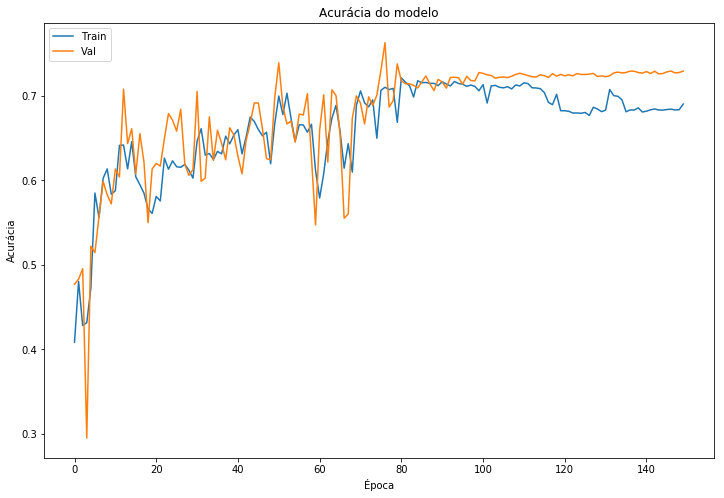

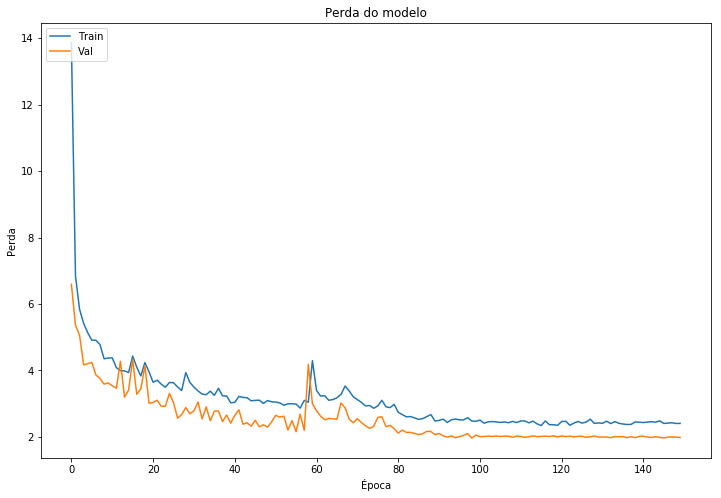

In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=[12,8])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Acurácia do modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=[12, 8])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## 6. Make predictions

Now let's make some predictions on the test dataset with the trained model. For convenience we'll use the test generator in the same way we set up above. Feel free to change the batch size.

You can set the `shuffle` option to `False` if you would like to check the model's progress on the same image(s) over the course of the training.

In [46]:
# 1: Set the test dataset.
test_dataset.parse_xml(images_dirs=[IVM_imgs_dir],
                       image_set_filenames=[IVM_general_test,
                                            IVM_all_test,
                                            IVM_all_split_test,
                                            IVM_cns_test,
                                            IVM_cns_unseen_test_test,
                                            IVM_selected_frames_test],
                       annotations_dirs=[IVM_anno_dir],
                       classes=classes,
                       include_classes='all',
                       exclude_truncated=False,
                       exclude_difficult=True,
                       ret=False)

# 2: Set the generator for the predictions.
predict_generator = test_dataset.generate(batch_size=10,
                                          shuffle=True,
                                          transformations=[convert_to_3_channels,
                                                           resize],
                                          label_encoder=None,
                                          returns={'processed_images',
                                                   'filenames',
                                                   'inverse_transform',
                                                   'original_images',
                                                   'original_labels'},
                                          keep_images_without_gt=False)

# 3: Generate samples.
batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

print(batch_filenames)

#iter é a variável que diz qual o batch de imagens olhar
for iter in range(9):
    print("Image:", batch_filenames[iter])
    print()
    print("Ground truth boxes:\n")
    print(np.array(batch_original_labels[iter]))
    print('\n')

# 4: Make predictions.
y_pred = model.predict(batch_images)

Loading images into memory: 100%|██████████| 9/9 [00:00<00:00, 74.25it/s]
['dataset/frames/Foto-0105.jpg', 'dataset/frames/Foto-0023_1.jpg', 'dataset/frames/control-2-medula-curva-inflamada-0014_t010024.jpg', 'dataset/frames/vd_2_codec_v1_t001_0000.jpg', 'dataset/frames/Foto-0015.jpg', 'dataset/frames/Foto-0012_1.jpg', 'dataset/frames/vd_3_codec_v1_t001_0000.jpg', 'dataset/frames/vd_1_codec_v1_t001_0000.jpg', 'dataset/frames/control-2-medula-curva-inflamada-0023_t0010008.jpg']
Image: dataset/frames/Foto-0105.jpg

Ground truth boxes:

[[   1 1024  460 1042  475]
 [   1  828  464  847  480]
 [   1  837  486  858  504]
 [   1  635  483  647  494]
 [   1  478  443  495  459]
 [   1  489  423  502  437]
 [   1  473  416  488  433]
 [   1  469  394  485  407]
 [   1  432  413  448  428]
 [   1  455  431  470  445]
 [   1  365  432  385  451]
 [   1  400  388  415  403]
 [   1  422  396  437  414]
 [   1  204  330  219  345]
 [   1  280  369  297  385]
 [   1  475  348  487  359]
 [   1  480 

Now let's decode the raw predictions in `y_pred`.

Had we created the model in __inference__ or __inference_fast__ mode, then the model's final layer would be a `DecodeDetections` layer and `y_pred` would already contain the decoded predictions, but since we created the model in __training__ mode, the model outputs raw predictions that still need to be decoded and filtered. This is what the `decode_detections()` function is for. It does exactly what the `DecodeDetections` layer would do, but using Numpy instead of TensorFlow (i.e. on the CPU instead of the GPU).

`decode_detections()` with default argument values follows the procedure of the original SSD implementation: First, a very low confidence threshold of 0.01 is applied to filter out the majority of the predicted boxes, then greedy non-maximum suppression (NMS) is performed per class with an intersection-over-union (IoU) threshold of 0.45, and out of what is left after that, the top 200 highest confidence boxes are returned. Those settings are for precision-recall scoring purposes though. In order to get some usable final predictions, we'll set the confidence threshold much higher, e.g. to 0.5, since we're only interested in the very confident predictions.

In [47]:
# 5: Decode the raw predictions in `y_pred`.
y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.25,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

We made the predictions on the resized images, but we'd like to visualize the outcome on the original input images, so we'll convert the coordinates accordingly. Don't worry about that opaque `apply_inverse_transforms()` function below, in this simple case it just aplies `(* original_image_size / resized_image_size)` to the box coordinates.

In [48]:
# 6: Convert the predictions for the original image.
y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
for iter in range(9):
    print(y_pred_decoded_inv[i])
    print()

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[   1.      0.94  744.    584.    769.    606.  ]
 [   1.      0.92 1159.    394.   1188.    424.  ]
 [   1.      0.88  933.    454.    964.    475.  ]
 [   1.      0.87  487.     94.    512.    118.  ]
 [   1.      0.76  984.    386.   1005.    404.  ]
 [   1.      0.66  612.    289.    636.    312.  ]
 [   1.      0.64  682.    543.    711.    568.  ]
 [   1.      0.51  540.    207.    562.    230.  ]
 [   1.      0.41  188.    411.    222.    447.  ]
 [   1.      0.41  231.    412.    269.    453.  ]
 [   1.      0.39  913.    161.    938.    187.  ]
 [   1.      0.34  558.    708.    594.    746.  ]
 [   1.      0.32  513.    564.    540.    590.  ]
 [   1.      0.29 1035.    390.   1057.    405.  ]
 [   1.      0.28  719.    604.    738.    624.  ]]

[[   1.      0.94  744.    584.    769.    606.  ]
 [   1.      0.92 1159.    394.   1188.    424.  ]
 [   1.      0.88  933.    454.    964.    475.  ]
 [   1.      0.87  4

Finally, let's draw the predicted boxes onto the image. Each predicted box says its confidence next to the category name. The ground truth boxes are also drawn onto the image in green for comparison.

['dataset/frames/Foto-0105.jpg', 'dataset/frames/Foto-0023_1.jpg', 'dataset/frames/control-2-medula-curva-inflamada-0014_t010024.jpg', 'dataset/frames/vd_2_codec_v1_t001_0000.jpg', 'dataset/frames/Foto-0015.jpg', 'dataset/frames/Foto-0012_1.jpg', 'dataset/frames/vd_3_codec_v1_t001_0000.jpg', 'dataset/frames/vd_1_codec_v1_t001_0000.jpg', 'dataset/frames/control-2-medula-curva-inflamada-0023_t0010008.jpg']


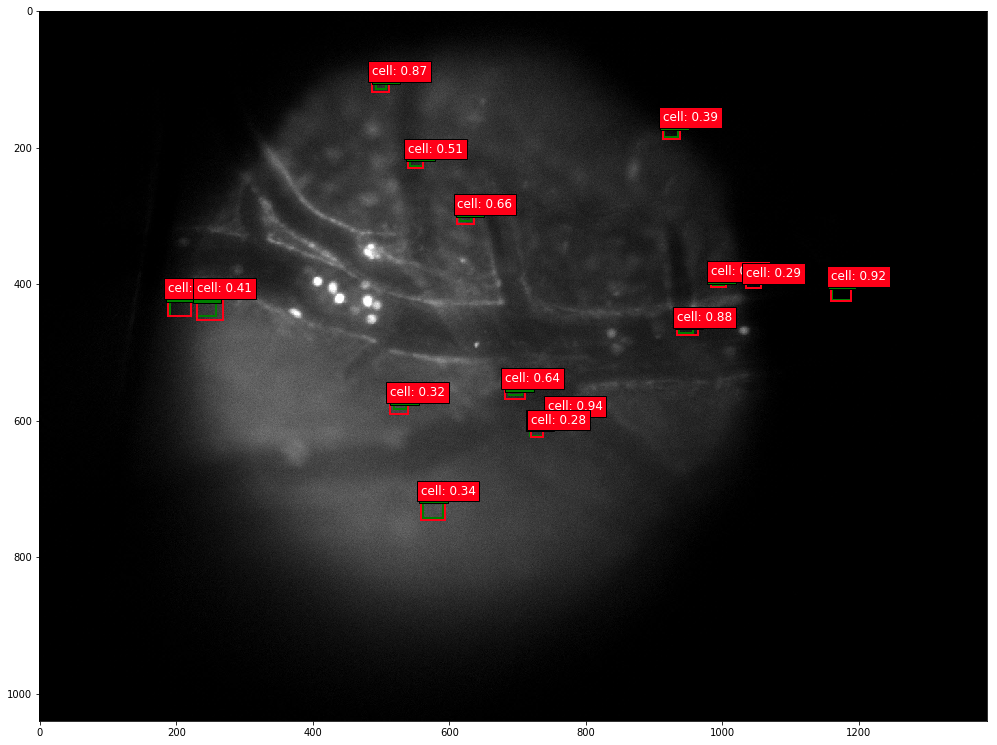

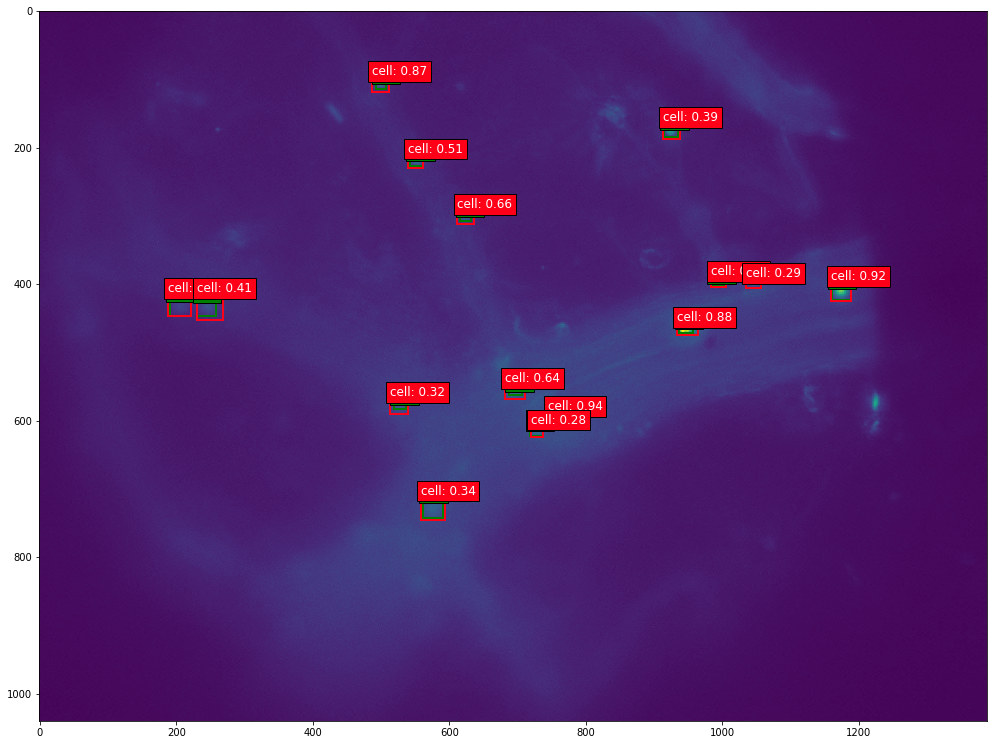

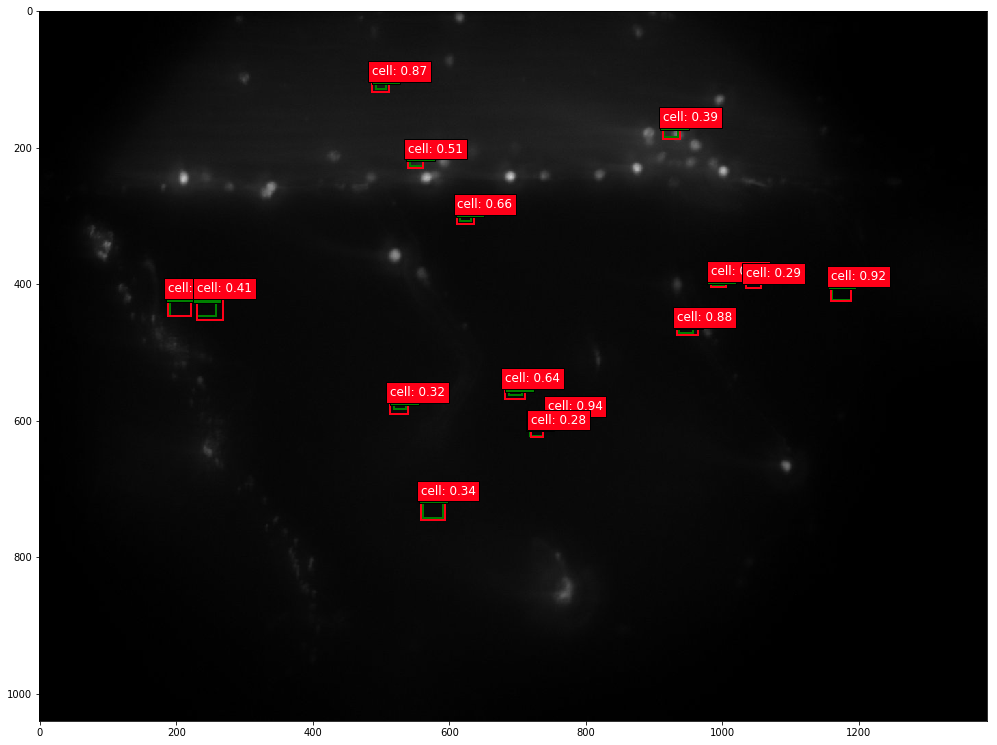

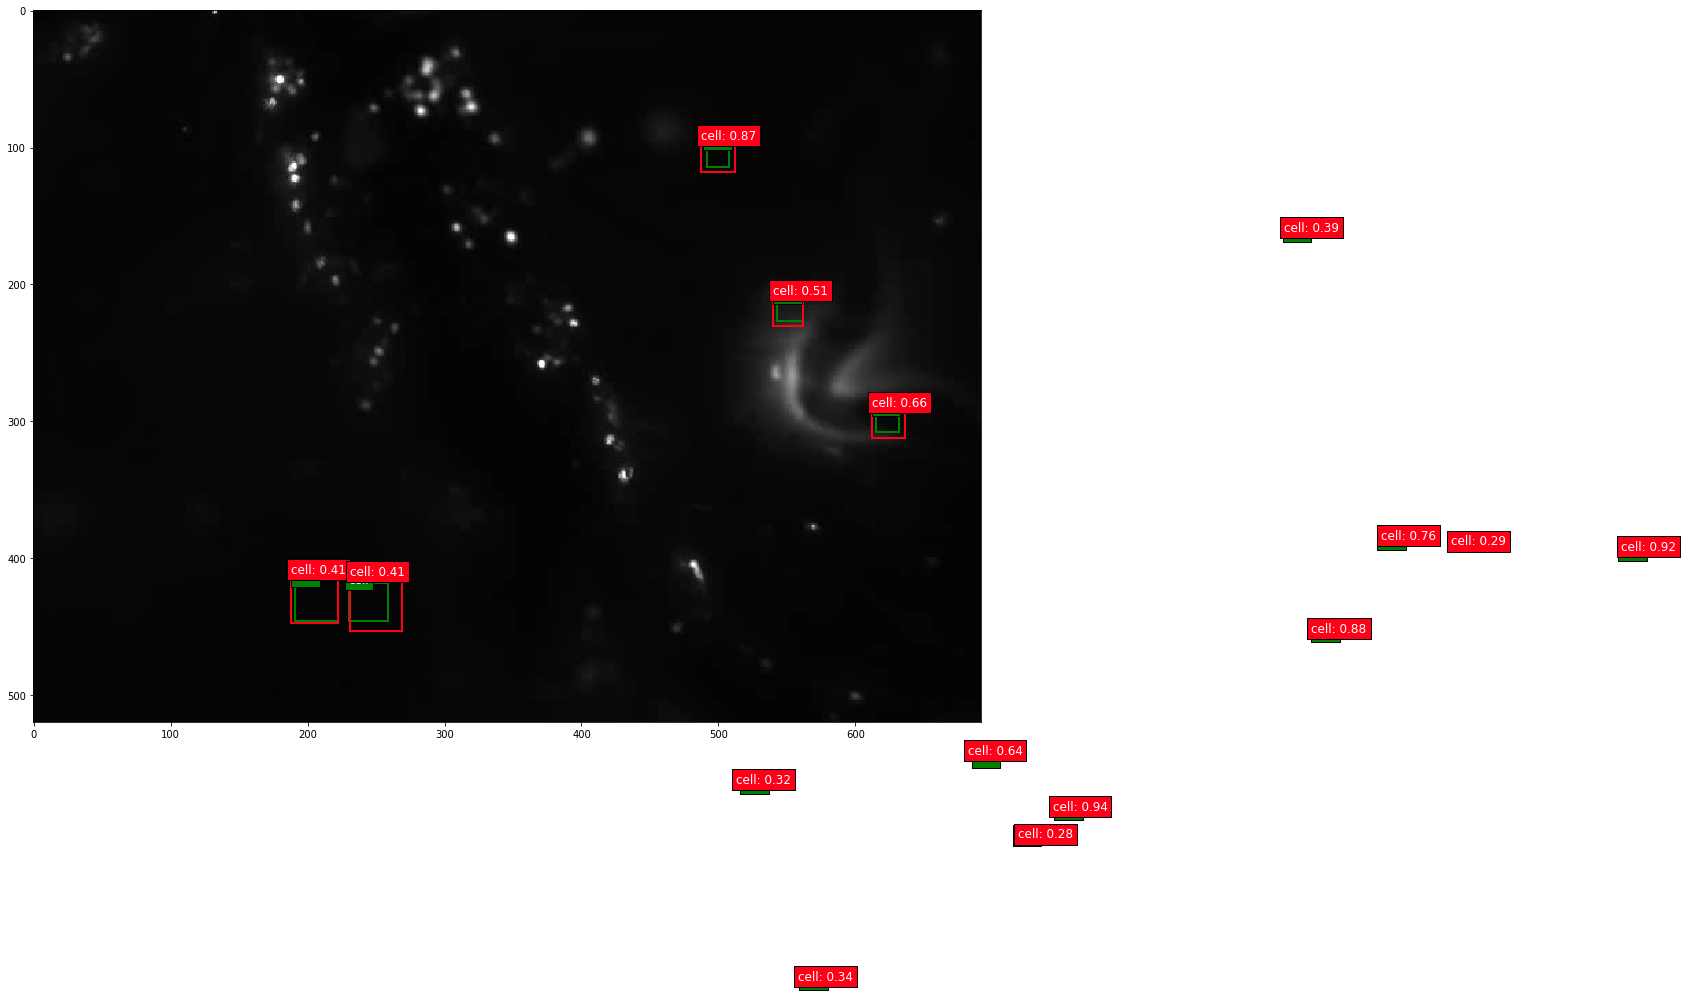

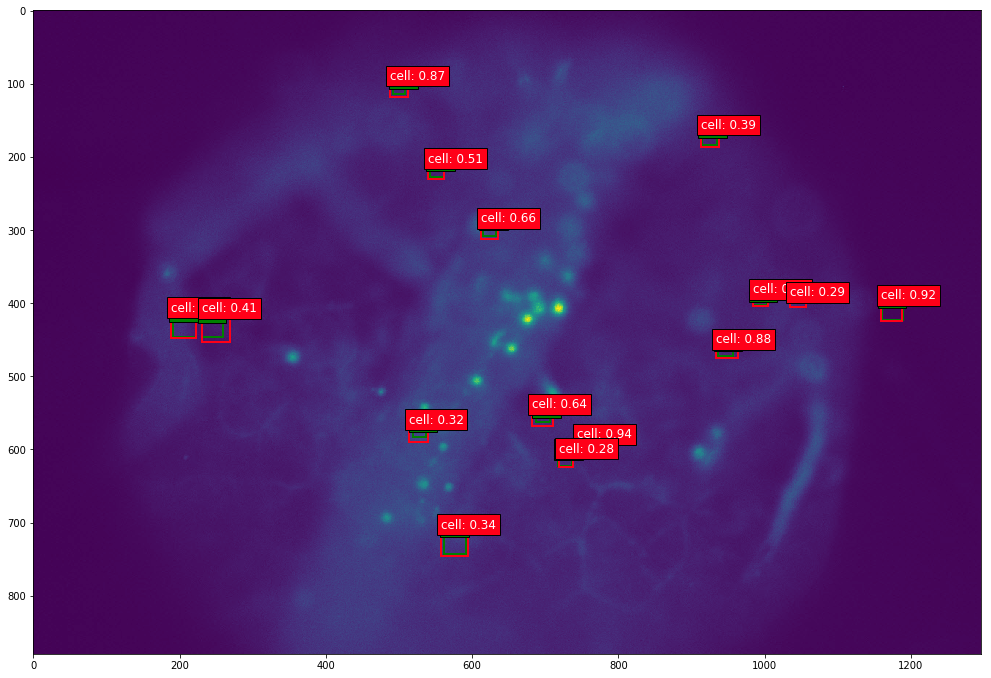

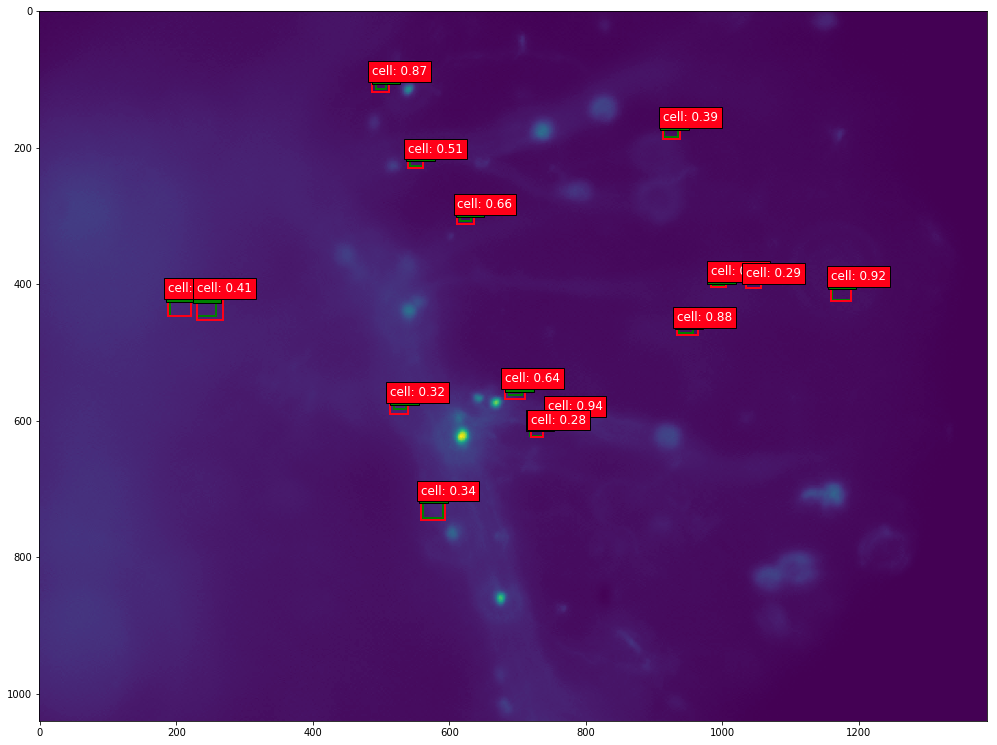

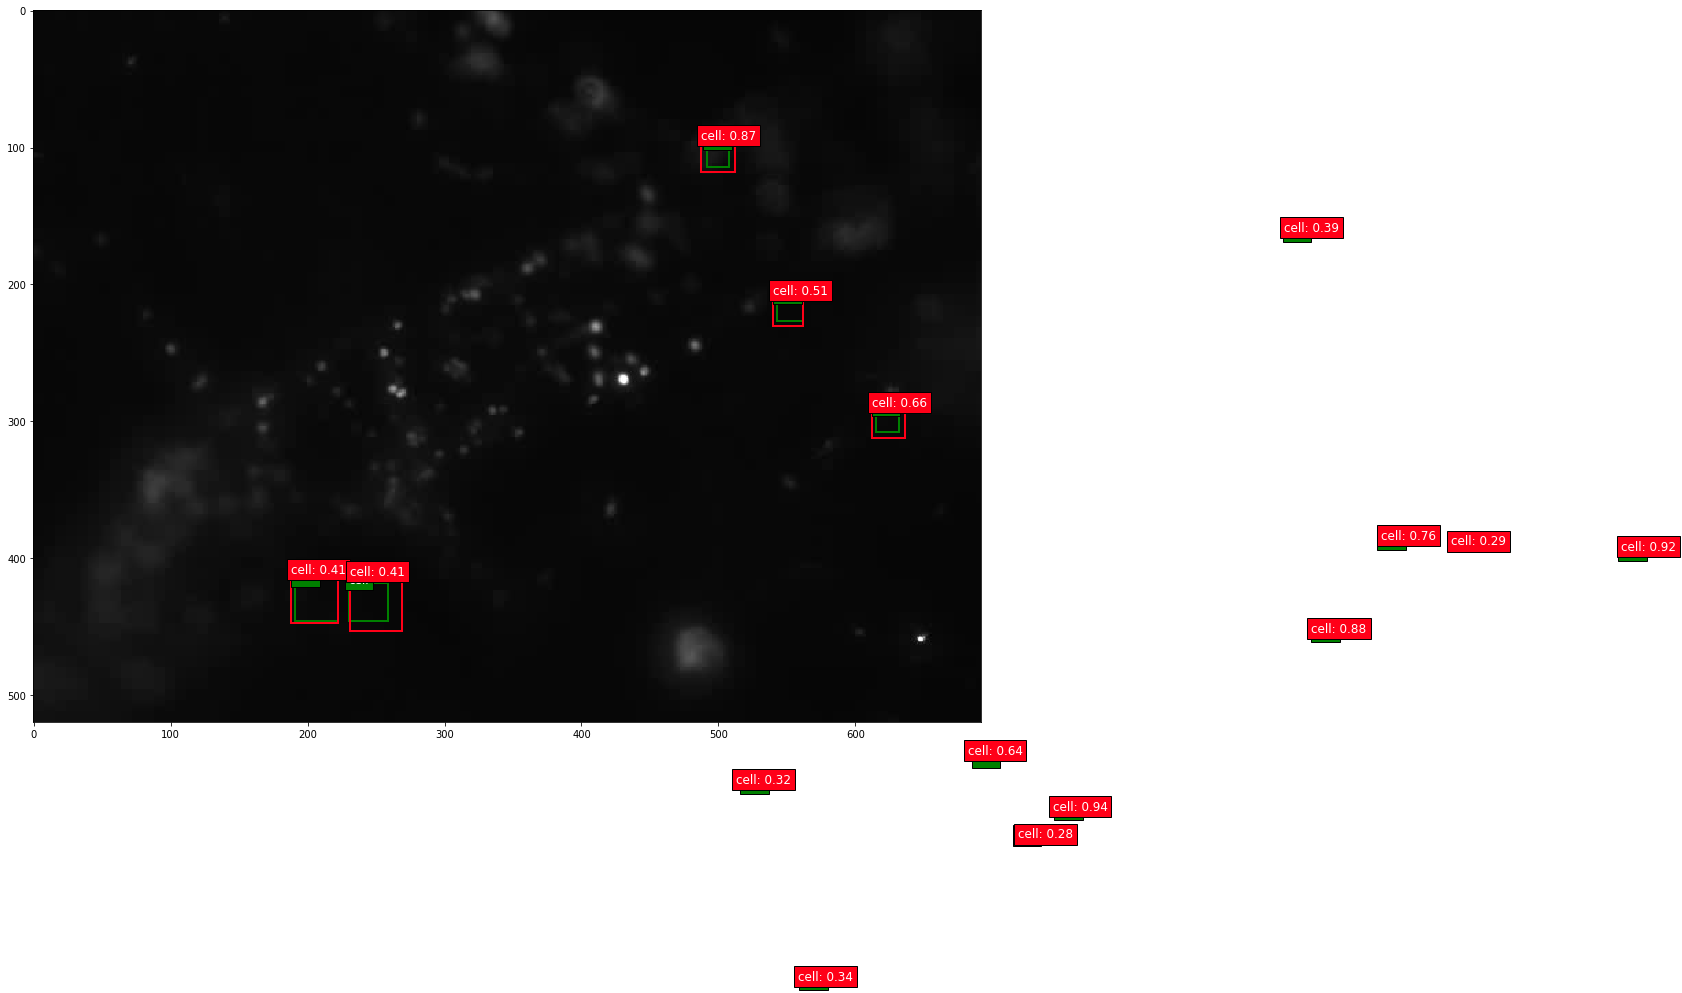

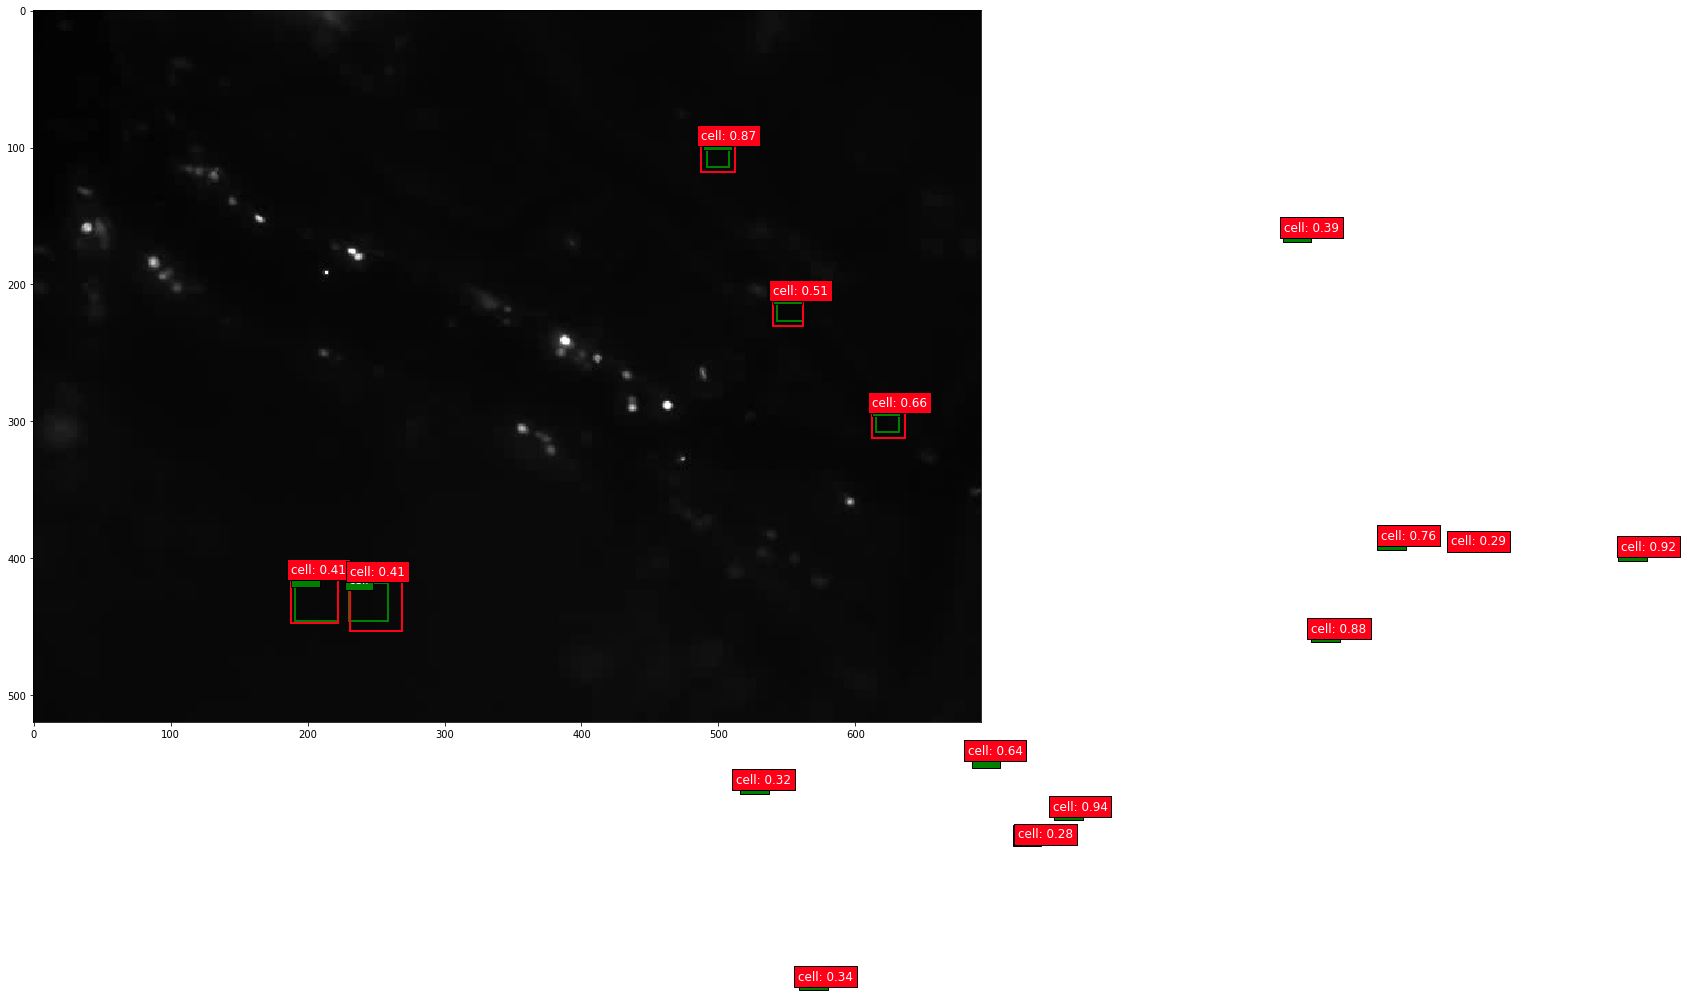

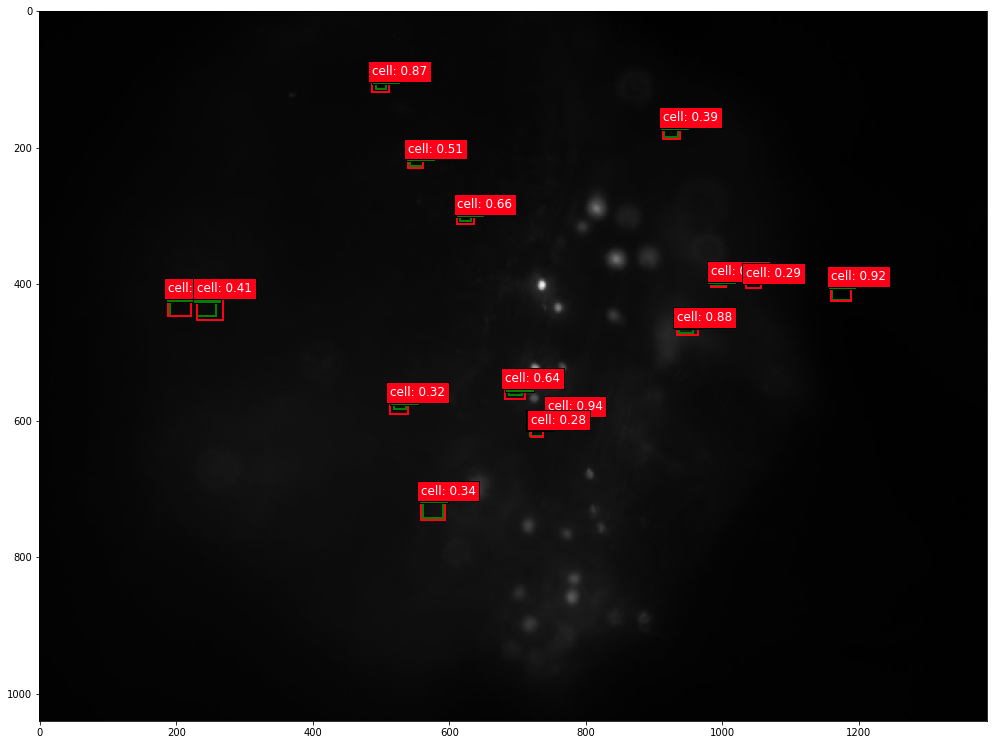

In [49]:
# 7: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background', 'cell']

print(batch_filenames)

for iter in range(9):
    plt.figure(figsize=(180, 108))
    plt.subplot(1, 9, iter + 1)
    plt.imshow(batch_original_images[iter])


    current_axis = plt.gca()

    for box in batch_original_labels[i]:
        xmin = box[1]
        ymin = box[2]
        xmax = box[3]
        ymax = box[4]
        label = '{}'.format(classes[int(box[0])])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))
        current_axis.text(xmin, ymin, label, size='large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

    for box in y_pred_decoded_inv[i]:
        xmin = box[2]
        ymin = box[3]
        xmax = box[4]
        ymax = box[5]
        color = colors[int(box[0])]
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
        current_axis.text(xmin, ymin, label, size='large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [50]:
from eval_utils.average_precision_evaluator import Evaluator
dataset = DataGenerator()
dataset.parse_xml(images_dirs=[IVM_imgs_dir],
                  image_set_filenames=[IVM_general_test,
                                            IVM_all_test,
                                            IVM_all_split_test,
                                            IVM_cns_test,
                                            IVM_cns_unseen_test_test,
                                            IVM_selected_frames_test],
                  annotations_dirs=[IVM_anno_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)


evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode='training')

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=16,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Processing image set 'test.txt': 100%|██████████| 9/9 [00:00<00:00, 86.87it/s]
Number of images in the evaluation dataset: 9

Matching predictions to ground truth, class 1/1.: 100%|██████████| 1800/1800 [00:00<00:00, 21796.39it/s]
Computing precisions and recalls, class 1/1
Computing average precision, class 1/1


In [51]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

cell          AP    0.345

              mAP   0.345


Text(0.5, 1.0, 'cell, AP: 0.345')

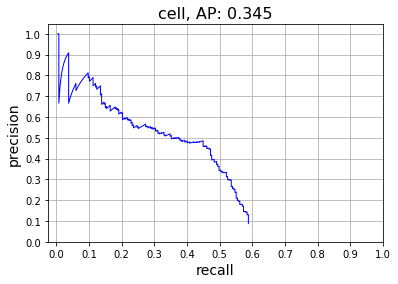

In [52]:
plt.figure()
plt.plot(recalls[1], precisions[1], color='blue', linewidth=1.0)
plt.xlabel('recall', fontsize=14)
plt.ylabel('precision', fontsize=14)
plt.grid(True)
plt.xticks(np.linspace(0,1,11))
plt.yticks(np.linspace(0,1,11))
plt.title("{}, AP: {:.3f}".format(classes[1], average_precisions[1]), fontsize=16)

In [53]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.45, # IoU changed
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)


Matching predictions to ground truth, class 1/1.: 100%|██████████| 1800/1800 [00:00<00:00, 18327.25it/s]
Computing precisions and recalls, class 1/1
Computing average precision, class 1/1


In [54]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], 'AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

cell          AP    0.509

              mAP   0.345
